# **Word Embedding Model Training and Evaluation**
This notebook demonstrates the training and evaluation of a dense embedding model using Word2Vec (Skip-Gram) on a preprocessed text dataset. The workflow includes:
1. Loading and preprocessing the dataset.
2. Training the Word2Vec model.
3. Embedding Summary.
4. Computing semantic similarity between words.
5. Visualizing the embeddings and similarity results.

**Mount Google Drive and Load Dataset**
This section mounts Google Drive to access the dataset files.


In [13]:
import os
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/datasetfiles/'
files = os.listdir(folder_path)
print("Files in directory:", files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in directory: ['Cleaned_file_1.txt', 'Cleaned_file_3.txt', 'Cleaned_file_2.txt', 'Cleaned_file_8.txt', 'Cleaned_file_9.txt', 'Cleaned_file_10.txt', 'Cleaned_file_5.txt', 'Cleaned_file_6.txt', 'Cleaned_file_4.txt', 'Cleaned_file_7.txt']


**Data Loading and Preprocessing**
The dataset is preprocessed to prepare it for training:
- Tokenization: Splitting text into words.
- Stopword Removal: Removing commonly used words with low semantic value.
- Lowercasing: Converting text to lowercase for uniformity.
The processed dataset is stored as a list of tokenized documents.

In [14]:
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
documents = []

for filename in files:
    with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
        text = file.read()
        tokens = [word for word in simple_preprocess(text) if word not in stop_words]  #  remove stop words
        documents.append(tokens)

print(f"Loaded and processed {len(documents)} documents.")

Loaded and processed 10 documents.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 **Training the Word2Vec Model**
The Word2Vec model is trained using the Skip-Gram approach, which predicts the surrounding context for a given word. Key hyperparameters include:
- Embedding dimension: 30
- Context window size: 5 words
- Minimum word frequency: 2
- Learning rate: Adjusted over 100 training epochs

The model learns semantic relationships between words, producing embeddings that are saved for evaluation.


In [15]:
from gensim.models import Word2Vec

embedding_dim = 30
model = Word2Vec(
    sentences=documents,
    vector_size=embedding_dim,
    window=5,
    min_count=2,
    sg=1,  # using Skip gram model
    epochs=100,
    alpha=0.03,
    min_alpha=0.001
)

print("Word2Vec model trained.")

Word2Vec model trained.


**Save Word Embeddings**
The trained word embeddings are saved to a text file

In [16]:
model.wv.save_word2vec_format('/content/word_embeddings.txt', binary=False)
print("Word embeddings saved to 'word_embeddings.txt'.")

Word embeddings saved to 'word_embeddings.txt'.


**Embedding Structure**
This section demonstrates:
1. Word embeddings for selected sample words from the dataset.
2. The vector representation across all 30 dimensions.


In [19]:
import pandas as pd
import numpy as np


# Display the shape of the embeddings matrix
embedding_matrix = model.wv.vectors
print(f"Embedding matrix shape: {embedding_matrix.shape}")

num_words, embedding_dim = embedding_matrix.shape
print(f"Number of words: {num_words}")
print(f"Embedding dimension: {embedding_dim}")


# Display embeddings for some words in the vocabulary
sample_words = ["identity", "registration", "project", "security", "card", "nadra"]
sample_embeddings = {word: model.wv[word] for word in sample_words if word in model.wv}

print("Sample Word Embeddings:")
for word, embedding in sample_embeddings.items():
    print(f"{word}: {embedding}")

# convert to a DataFrame for a cleaner display
embedding_df = pd.DataFrame(
    sample_embeddings
)
print("\nSample Embeddings as DataFrame:")
print(embedding_df)


Embedding matrix shape: (433, 30)
Number of words: 433
Embedding dimension: 30
Sample Word Embeddings:
identity: [-0.47370788 -0.34037572  0.2387438   0.16254635 -0.49466828  0.18916711
  0.509218    0.7670908   0.27811    -0.40262374  0.10738358 -0.4085891
 -0.11807323 -1.3300141   0.5074279  -0.45272192  0.25277618  0.0135094
  0.0727261  -0.53115404  0.522026   -0.06360832  0.12740903  0.7639577
 -0.5757442  -0.41095024  1.1414431   0.6854948  -0.5055022  -0.46924484]
registration: [-0.01647476 -0.6393873  -0.23282054  0.16806541 -0.02157548  0.09105916
  0.57509804  0.9212992  -0.4770271   0.37314874  1.2156146   0.04322197
  0.4543087  -0.690611   -0.09156779  0.15462898  0.43838117 -0.6118084
 -0.39342502 -0.99269205  0.29252377  0.5388215   0.8130537   0.21335433
 -0.63114756 -0.4758681   0.86930144  0.8553824   0.786466    0.9254444 ]
project: [ 0.28361976  0.14485586 -0.4102116  -0.32825184 -1.5857241   1.3707576
  1.541086   -0.36800772 -0.58737564 -0.6290259   0.8081207   0.

 **Evaluation of Word Embeddings**
This section evaluates the trained embeddings:
1. **Cosine Similarity:** Measures semantic closeness between words by computing the cosine of the angle between their embedding vectors.
2. **Similarity Matrix:** Displays a subset (6x6) of the similarity matrix for clarity and saves the full matrix as a CSV.
3. **2D Visualization:** Uses t-SNE for dimensionality reduction to plot relationships between embeddings.


In [20]:
from sklearn.metrics.pairwise import cosine_similarity

words_in_vocab = list(model.wv.index_to_key)
similarity_data = {}

# Compute cosine similarity for each word pair
for word1 in words_in_vocab:
    similarity_data[word1] = []
    for word2 in words_in_vocab:
        if word1 in model.wv and word2 in model.wv:
            similarity_score = cosine_similarity([model.wv[word1]], [model.wv[word2]])[0][0]
        else:
            similarity_score = None
        similarity_data[word1].append(similarity_score)

similarity_df = pd.DataFrame(similarity_data, index=words_in_vocab)
# Saving the full cosine similarity matrix to a CSV file
similarity_df.to_csv("/content/drive/MyDrive/cosine_similarity_matrix.csv")
print("Cosine Similarity matrix has been successfully saved.")

Cosine Similarity matrix has been successfully saved.


Cosine Similarity

In [21]:
#  printing only a 6x6 subset of the similarity matrix for clarity and readability
subset_similarity_df = similarity_df.iloc[:6, :6]
print("Cosine Similarity Matrix for 6x6")
print(subset_similarity_df)

Cosine Similarity Matrix for 6x6
                 nadra  identity  registration  downloads      card  projects
nadra         1.000000  0.256452      0.451311   0.403554  0.319771  0.436730
identity      0.256452  1.000000      0.439070   0.211899  0.556876  0.355257
registration  0.451311  0.439070      1.000000   0.258924  0.383014  0.492361
downloads     0.403554  0.211899      0.258924   1.000000  0.406657  0.439047
card          0.319771  0.556876      0.383014   0.406657  1.000000  0.378983
projects      0.436730  0.355257      0.492361   0.439047  0.378983  1.000000


2D Visualization

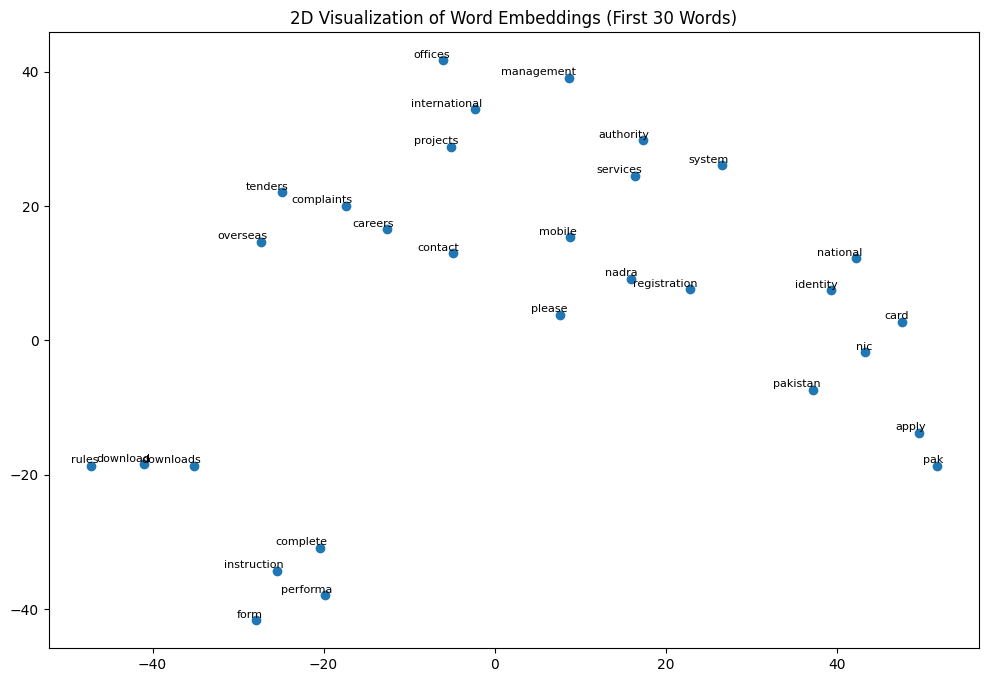

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Select first 30 words for visualization. Limited to 30 words for clarity.
words_in_vocab = list(model.wv.index_to_key)[:30]
word_vectors = np.array([model.wv[word] for word in words_in_vocab])
tsne = TSNE(n_components=2, random_state=0, perplexity=5)
word_embeddings_2d = tsne.fit_transform(word_vectors)
plt.figure(figsize=(12, 8))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], marker='o')
for i, word in enumerate(words_in_vocab):
    plt.annotate(word, xy=(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]),
                 xytext=(5, 2), textcoords='offset points', ha='right', fontsize=8)

plt.title("2D Visualization of Word Embeddings (First 30 Words)")
plt.show()

